#### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

#### Read Data

In [4]:
data = pd.read_csv(r'C:\Users\radha\OneDrive\Desktop\flood_dataset.csv')

In [5]:
data.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,8.0,8,4,5,2,5,3,54.598150,9,3,...,4.0,4,7,3,1,0,5,7,13,0.399695
1,7.0,9,2,6,4,7,2,20.085537,7,2,...,7.0,3,4,2,4,4,4,8,5,0.313546
2,5.0,6,7,8,8,4,10,8103.083928,5,7,...,4.0,5,7,7,2,3,2,4,4,0.390890
3,4.0,2,3,10,8,6,3,148.413159,4,8,...,3.0,3,0,3,3,5,5,7,6,0.371446
4,7.0,3,9,5,4,6,6,8103.083928,4,7,...,7.0,6,4,8,6,5,6,10,2,0.418979


#### Check for Missing Values

In [7]:
print(data.isna().sum())

MonsoonIntensity                   2526
TopographyDrainage                    0
RiverManagement                       0
Deforestation                         0
Urbanization                          0
ClimateChange                         0
DamsQuality                           0
Siltation                             0
AgriculturalPractices                 0
Encroachments                         0
IneffectiveDisasterPreparedness       0
DrainageSystems                    2528
CoastalVulnerability                  0
Landslides                            0
Watersheds                            0
DeterioratingInfrastructure           0
PopulationScore                       0
WetlandLoss                           0
InadequatePlanning                    0
PoliticalFactors                      0
FloodProbability                      0
dtype: int64


In [8]:
data['MonsoonIntensity'] = data['MonsoonIntensity'].fillna(data['MonsoonIntensity'].median())
data['DrainageSystems'] = data['DrainageSystems'].fillna(data['DrainageSystems'].median())

print(data.isna().sum())

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64


#### Removing Duplicates 

In [10]:
print(data.duplicated().sum())
print(data.info())

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50500 entries, 0 to 50499
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50500 non-null  float64
 1   TopographyDrainage               50500 non-null  int64  
 2   RiverManagement                  50500 non-null  int64  
 3   Deforestation                    50500 non-null  int64  
 4   Urbanization                     50500 non-null  int64  
 5   ClimateChange                    50500 non-null  int64  
 6   DamsQuality                      50500 non-null  int64  
 7   Siltation                        50500 non-null  float64
 8   AgriculturalPractices            50500 non-null  int64  
 9   Encroachments                    50500 non-null  int64  
 10  IneffectiveDisasterPreparedness  50500 non-null  int64  
 11  DrainageSystems                  50500 non-null  float64
 12  CoastalVulnerabi

####  Outlier Detection and Handling

In preparing the dataset for linear regression modeling, we adopted an outlier capping (winsorization) approach to handle extreme values. This technique adjusts outliers by limiting them to a specified percentile range (based on the IQR method), rather than removing them entirely. This is especially important for linear regression, which is highly sensitive to extreme values — a few large outliers can disproportionately influence the model's coefficients and lead to distorted predictions. Capping allows us to retain all data points, preserving sample size and avoiding information loss, while reducing the influence of outliers that could skew model training. Compared to outright removal, this method provides a balanced solution that improves robustness without discarding potentially valuable data.


In [13]:
flood_probability_before = data['FloodProbability'].copy()
monsoon_intensity_before = data['MonsoonIntensity'].copy()

In [15]:
for col in data.select_dtypes(include=np.number).columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data[col] = np.clip(data[col], lower, upper)  

C:\Users\radha\AppData\Local\Temp\ipykernel_31268\1430754590.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


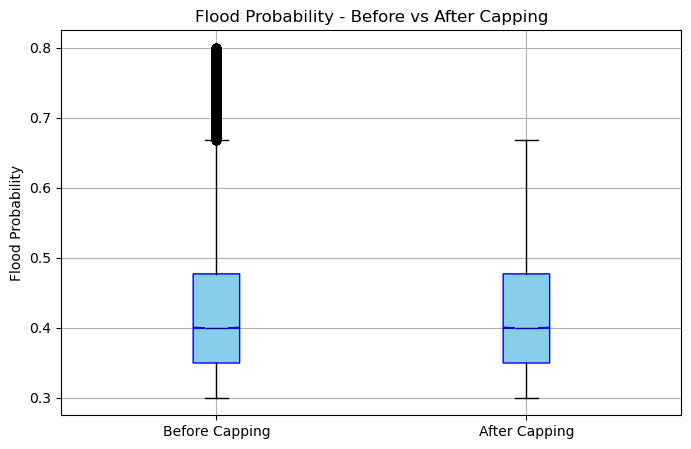

In [17]:
plt.figure(figsize=(8, 5))
plt.boxplot(
    [flood_probability_before, data['FloodProbability']],
    labels=['Before Capping', 'After Capping'],
    patch_artist=True,
    boxprops=dict(facecolor='skyblue', color='blue'),
    medianprops=dict(color='darkblue'),
    notch=True
)
plt.title('Flood Probability - Before vs After Capping')
plt.ylabel('Flood Probability')
plt.grid(True)
plt.show()

#### Handle skewness

In [21]:
from scipy.stats import skew
numeric_cols = data.select_dtypes(include=np.number)
skew_values = numeric_cols.apply(lambda x: skew(x.dropna()))
print(skew_values)

MonsoonIntensity                   0.313105
TopographyDrainage                 0.331810
RiverManagement                    0.299587
Deforestation                      0.308114
Urbanization                       0.099994
ClimateChange                      0.306402
DamsQuality                        0.309501
Siltation                          0.932128
AgriculturalPractices              0.298636
Encroachments                      0.321710
IneffectiveDisasterPreparedness    0.318728
DrainageSystems                    0.316135
CoastalVulnerability               0.315132
Landslides                         0.301299
Watersheds                         0.325875
DeterioratingInfrastructure        0.316409
PopulationScore                    0.317477
WetlandLoss                        0.306791
InadequatePlanning                 0.322237
PoliticalFactors                   0.314737
FloodProbability                   0.930199
dtype: float64


#### Histograms BEFORE log1p transformation

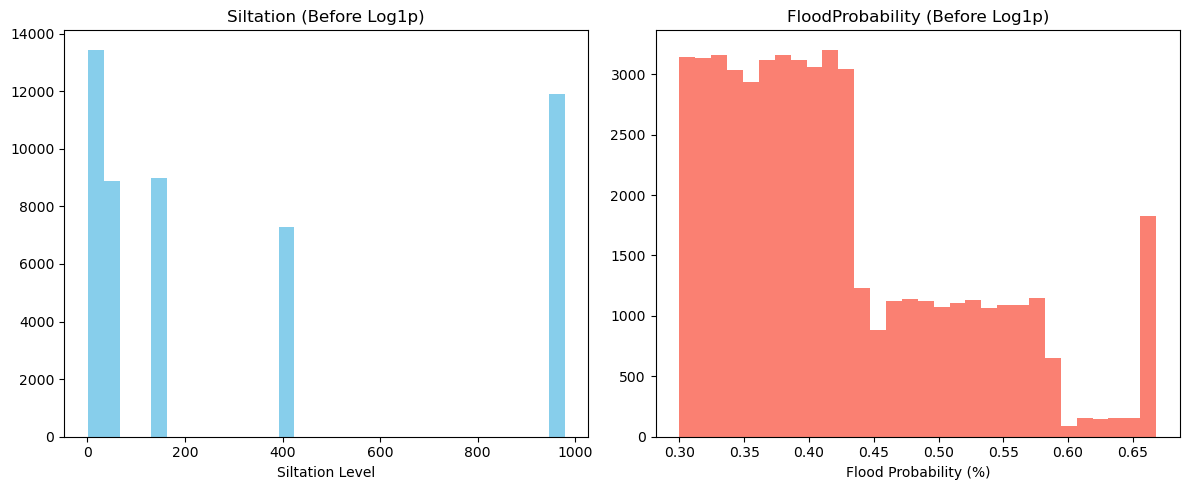

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(data['Siltation'].dropna(), bins=30, color='skyblue')
plt.title("Siltation (Before Log1p)")
plt.xlabel("Siltation Level")

plt.subplot(1, 2, 2)
plt.hist(data['FloodProbability'].dropna(), bins=30, color='salmon')
plt.title("FloodProbability (Before Log1p)")
plt.xlabel("Flood Probability (%)")

plt.tight_layout()
plt.show()

#### Apply log1p transformation to reduce right skew

In [33]:
data['Siltation'] = np.log1p(data['Siltation'])
data['FloodProbability'] = np.log1p(data['FloodProbability'])

#### Histograms AFTER log1p transformation

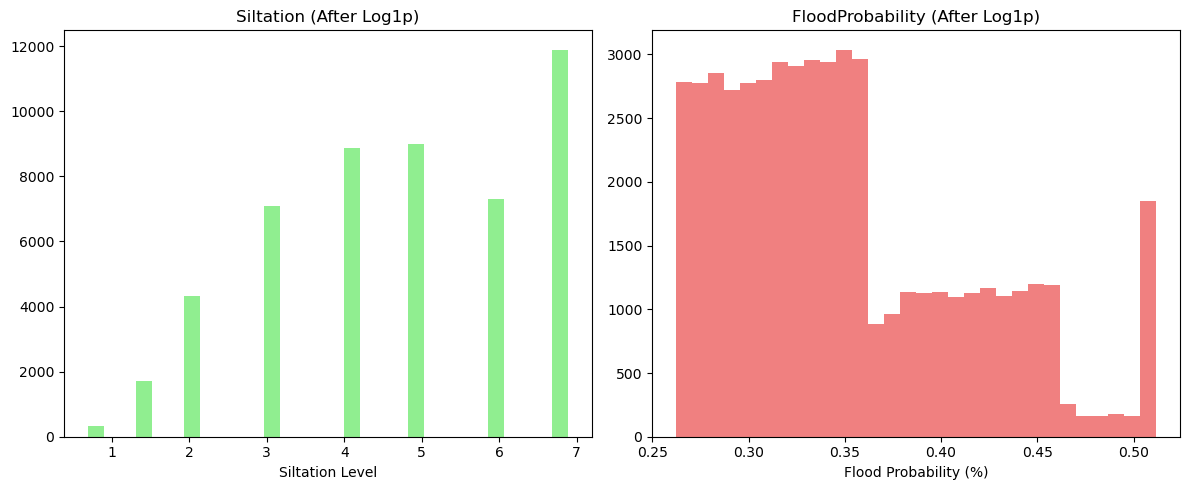

In [38]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(data['Siltation'].dropna(), bins=30, color='lightgreen')
plt.title("Siltation (After Log1p)")
plt.xlabel("Siltation Level")

plt.subplot(1, 2, 2)
plt.hist(data['FloodProbability'].dropna(), bins=30, color='lightcoral')
plt.title("FloodProbability (After Log1p)")
plt.xlabel("Flood Probability (%)")

plt.tight_layout()
plt.show()

#### Standardize everything

In [42]:
from sklearn.preprocessing import StandardScaler
numeric_cols = data.select_dtypes(include='number').columns
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

#### Checking for Multicollinearity

Variable VIF	Interpretation - Urbanization - 3.31	Moderate multicollinearity, PopulationScore	- 2.6	Slight multicollinearity, Deforestation	- 1.7	Mild correlation, These are still below the common thresholds


1. VIF calculation

In [53]:
X = data.drop(columns='FloodProbability').select_dtypes(include='number').dropna()
X = sm.add_constant(X)  # add intercept for statsmodels

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data[vif_data["Variable"] != "const"]  # exclude constant

print(vif_data)


                           Variable       VIF
1                  MonsoonIntensity  1.000326
2                TopographyDrainage  1.000415
3                   RiverManagement  1.000390
4                     Deforestation  1.708728
5                      Urbanization  3.317803
6                     ClimateChange  1.000307
7                       DamsQuality  1.000276
8                         Siltation  1.000564
9             AgriculturalPractices  1.000305
10                    Encroachments  1.000528
11  IneffectiveDisasterPreparedness  1.000205
12                  DrainageSystems  1.000319
13             CoastalVulnerability  1.000479
14                       Landslides  1.000288
15                       Watersheds  1.000406
16      DeterioratingInfrastructure  1.000259
17                  PopulationScore  2.608264
18                      WetlandLoss  1.000414
19               InadequatePlanning  1.000667
20                 PoliticalFactors  1.000397


2. VIF Bar Plot

C:\Users\radha\AppData\Local\Temp\ipykernel_31268\1361286258.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vif_data, x="VIF", y="Variable", palette="Blues_d")


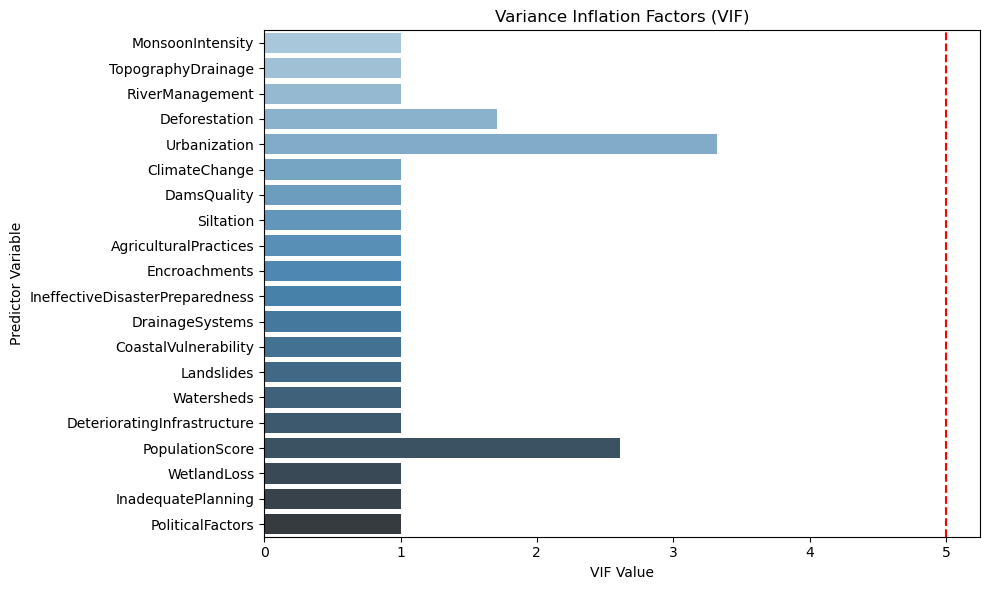

In [57]:
plt.figure(figsize=(10, 6))
sns.barplot(data=vif_data, x="VIF", y="Variable", palette="Blues_d")
plt.axvline(x=5, color='red', linestyle='--')
plt.title("Variance Inflation Factors (VIF)")
plt.xlabel("VIF Value")
plt.ylabel("Predictor Variable")
plt.tight_layout()
plt.show()

#### Feature Engineering

In [62]:
data['Urban_Drainage'] = data['Urbanization'] * data['DrainageSystems']
data['Deforestation_Siltation'] = data['Deforestation'] * data['Siltation']
data['Dams_Encroachments'] = data['DamsQuality'] * data['Encroachments']
data['Infrastructure_Planning'] = data['DeterioratingInfrastructure'] * data['InadequatePlanning']
data['Climate_Political'] = data['ClimateChange'] * data['PoliticalFactors']
data['Rainfall_vs_Topography'] = data['MonsoonIntensity'] / (data['TopographyDrainage'] + 1)
data['Population_vs_Planning'] = data['PopulationScore'] / (data['InadequatePlanning'] + 1)

#### EDA Visualization

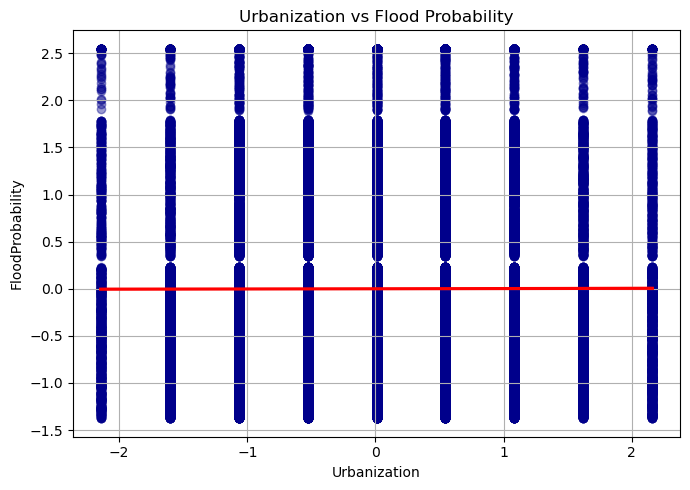

In [65]:
plt.figure(figsize=(7, 5))
sns.regplot(x='Urbanization', y='FloodProbability', data=data, scatter_kws={'alpha':0.4, 'color':'darkblue'}, line_kws={'color':'red'})
plt.title("Urbanization vs Flood Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

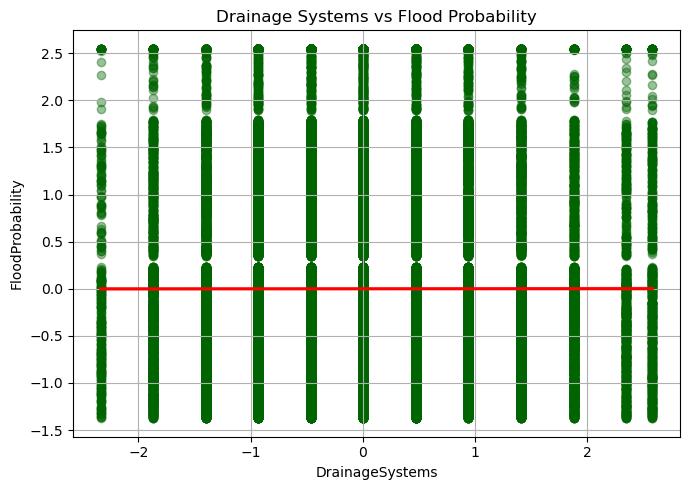

In [67]:
plt.figure(figsize=(7, 5))
sns.regplot(x='DrainageSystems', y='FloodProbability', data=data, scatter_kws={'alpha':0.4, 'color':'darkgreen'}, line_kws={'color':'red'})
plt.title("Drainage Systems vs Flood Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

### Research Question - 1 What are the most significant factors contributing to flood probability?


We employ multiple linear regression to analyze the relationships between independent variables such as MonsoonIntensity, DrainageSystems, deforestation, and flood probability.


                            OLS Regression Results                            
Dep. Variable:       FloodProbability   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6344
Date:                Fri, 27 Jun 2025   Prob (F-statistic):              0.928
Time:                        23:44:43   Log-Likelihood:                -71648.
No. Observations:               50500   AIC:                         1.434e+05
Df Residuals:                   50472   BIC:                         1.436e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

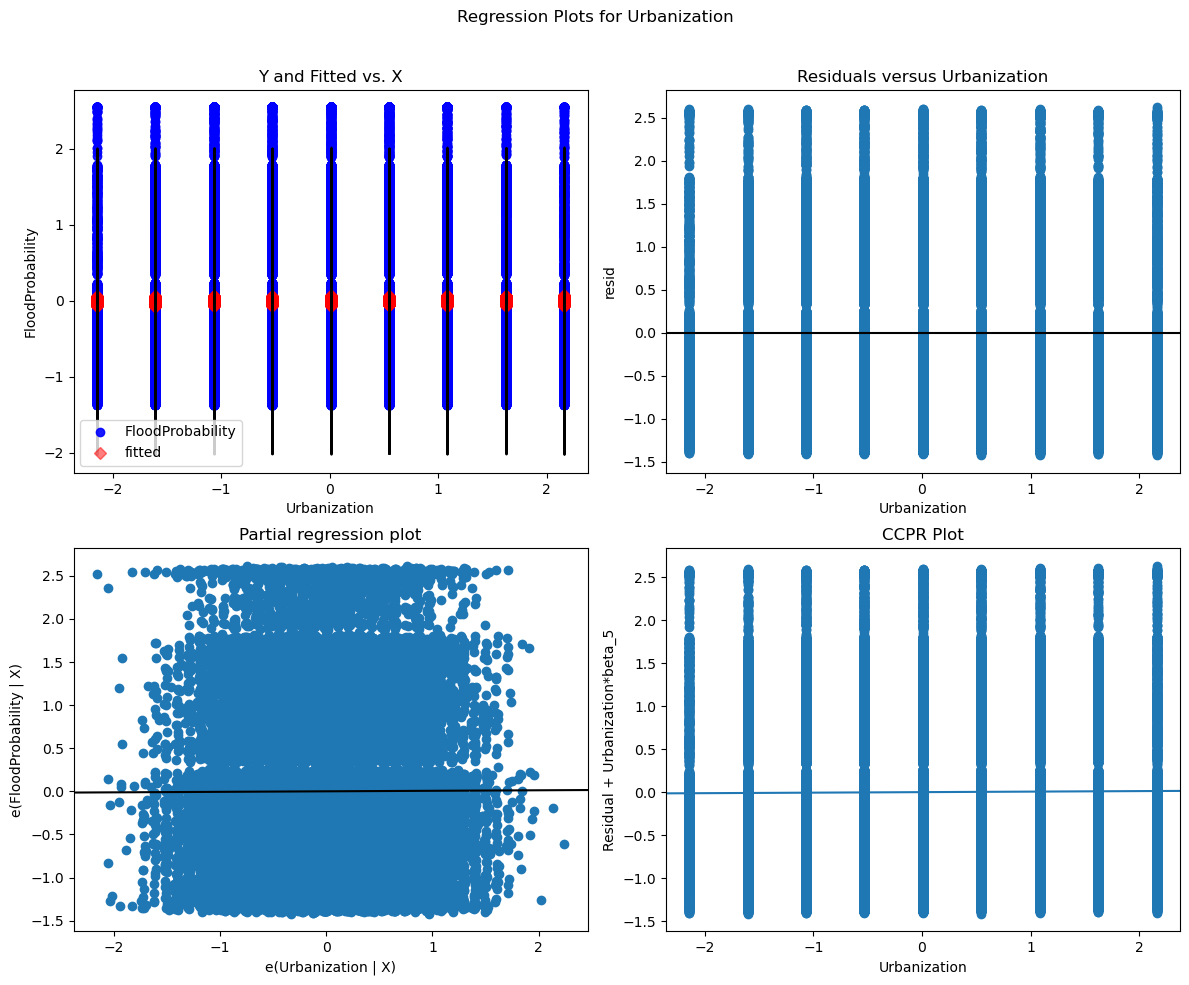

In [75]:
# Prepare X and y
X = data.drop(columns='FloodProbability')
X = sm.add_constant(X)  # intercept
y = data['FloodProbability']

# Fit model
lm_model = sm.OLS(y, X).fit()
print(lm_model.summary())

# Diagnostic plots
fig = plt.figure(figsize=(12, 10))
sm.graphics.plot_regress_exog(lm_model, "Urbanization", fig=fig)
plt.show()


Coefficient Bar Plot

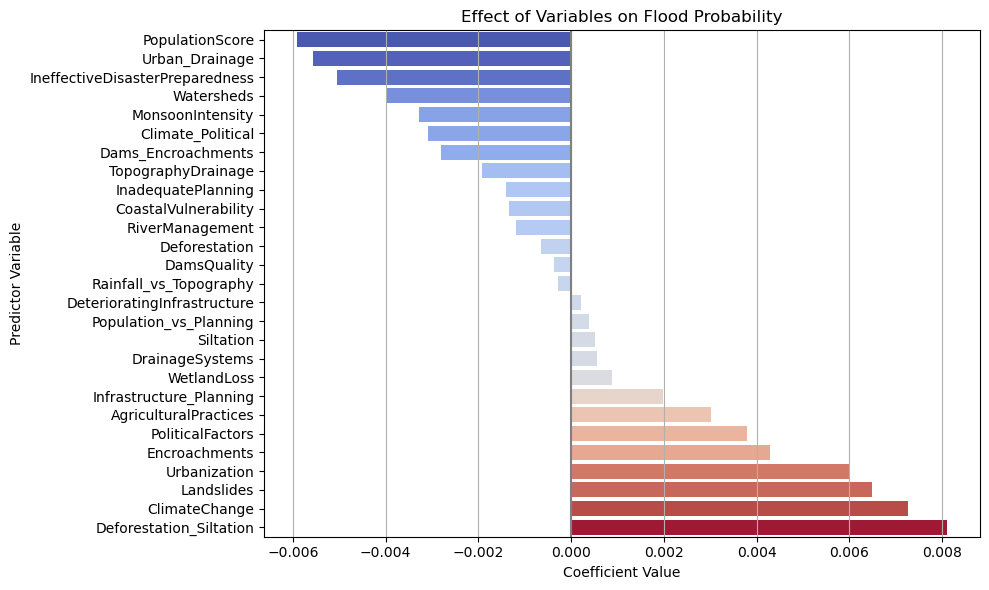

In [78]:
coeff = lm_model.params.drop('const')
coeff_df = pd.DataFrame({'Variable': coeff.index, 'Coefficient': coeff.values})
coeff_df = coeff_df.sort_values(by='Coefficient')

plt.figure(figsize=(10, 6))
sns.barplot(data=coeff_df, x='Coefficient', y='Variable', palette="coolwarm", hue='Coefficient', dodge=False)
plt.axvline(0, color='gray')
plt.title("Effect of Variables on Flood Probability")
plt.xlabel("Coefficient Value")
plt.ylabel("Predictor Variable")
plt.legend().remove()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

##### ANOVA + Breusch-Pagan Test

In [85]:
# Fit model using formula API instead of sm.OLS()
lm_model_formula = smf.ols('FloodProbability ~ ' + ' + '.join(data.drop(columns='FloodProbability').columns), data=data).fit()

# Now ANOVA will work
anova_results = anova_lm(lm_model_formula)
print(anova_results)

                                      df        sum_sq   mean_sq         F  \
MonsoonIntensity                     1.0      0.677100  0.677100  0.676954   
TopographyDrainage                   1.0      0.185926  0.185926  0.185886   
RiverManagement                      1.0      0.076740  0.076740  0.076723   
Deforestation                        1.0      0.233882  0.233882  0.233832   
Urbanization                         1.0      0.083905  0.083905  0.083887   
ClimateChange                        1.0      2.705008  2.705008  2.704425   
DamsQuality                          1.0      0.010143  0.010143  0.010141   
Siltation                            1.0      0.015141  0.015141  0.015138   
AgriculturalPractices                1.0      0.443071  0.443071  0.442976   
Encroachments                        1.0      0.899649  0.899649  0.899455   
IneffectiveDisasterPreparedness      1.0      1.231477  1.231477  1.231212   
DrainageSystems                      1.0      0.015660  0.015660

Fail to reject the null hypothesis → No significant evidence of heteroscedasticity.
The linear regression model satisfies the homoscedasticity assumption. This supports the reliability of the standard errors and p-values in the regression output — the coefficient interpretations are statistically valid under the classical linear model assumptions.


##### Ridge Regression 

In [91]:
# Prepare data (drop const)
X_ridge = data.drop(columns='FloodProbability')
y_ridge = data['FloodProbability']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_ridge)

# Fit Ridge with cross-validation
alphas = np.logspace(-4, 4, 100)
ridge_model = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_model.fit(X_scaled, y_ridge)

print(f"Best alpha: {ridge_model.alpha_}")

# Coefficients
ridge_coeffs = pd.Series(ridge_model.coef_, index=X_ridge.columns)
print(ridge_coeffs)

D:\python\Lib\site-packages\sklearn\linear_model\_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Best alpha: 10000.0
MonsoonIntensity                  -0.002702
TopographyDrainage                -0.001606
RiverManagement                   -0.001003
Deforestation                      0.000643
Urbanization                       0.002953
ClimateChange                      0.006082
DamsQuality                       -0.000329
Siltation                          0.000445
AgriculturalPractices              0.002507
Encroachments                      0.003569
IneffectiveDisasterPreparedness   -0.004202
DrainageSystems                    0.000450
CoastalVulnerability              -0.001139
Landslides                         0.005406
Watersheds                        -0.003299
DeterioratingInfrastructure        0.000164
PopulationScore                   -0.002934
WetlandLoss                        0.000751
InadequatePlanning                -0.001194
PoliticalFactors                   0.003150
Urban_Drainage                    -0.004658
Deforestation_Siltation            0.006800
Dams_Encroac

##### Re-fit Linear Model on Ridge-scaled Data

In [94]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X_ridge.columns)
X_scaled_df = sm.add_constant(X_scaled_df)
new_lm_model = sm.OLS(y_ridge, X_scaled_df).fit()
print(new_lm_model.summary())

                            OLS Regression Results                            
Dep. Variable:       FloodProbability   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6344
Date:                Sat, 28 Jun 2025   Prob (F-statistic):              0.928
Time:                        11:49:43   Log-Likelihood:                -71648.
No. Observations:               50500   AIC:                         1.434e+05
Df Residuals:                   50472   BIC:                         1.436e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

##### Random Forest + Variable Importance Plot

C:\Users\radha\AppData\Local\Temp\ipykernel_31268\5587276.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


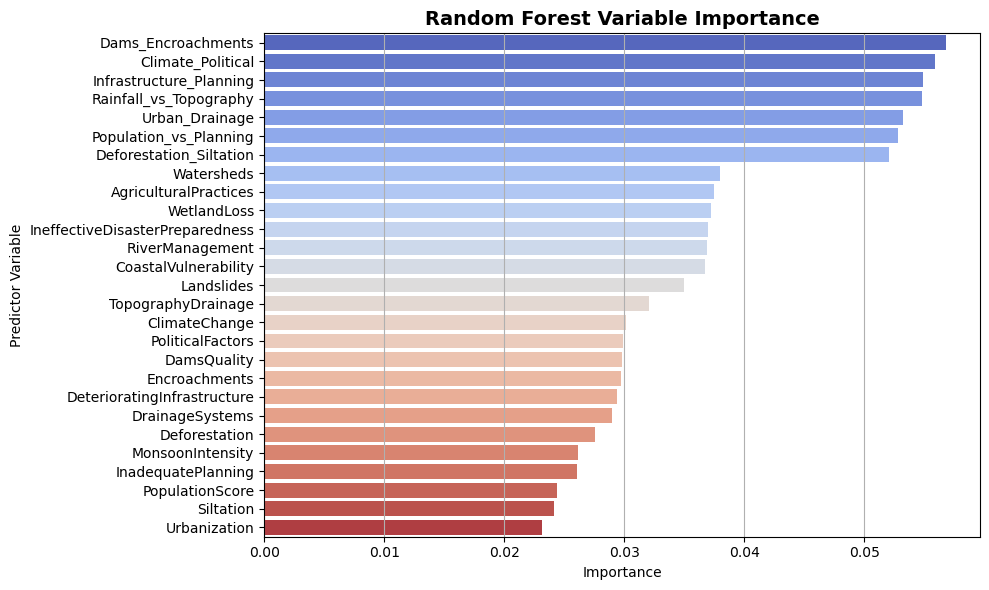

In [147]:
# STEP 1: DROP any non-numeric columns (like 'FloodRisk')
X_rf = data.drop(columns=["FloodProbability", "FloodRisk"], errors="ignore")
X_rf = X_rf.select_dtypes(include="number")  # Keep only numeric columns

# STEP 2: Define target
y_rf = data["FloodProbability"]

# STEP 3: Fit the Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf, y_rf)

# STEP 4: Get importance and plot
importance_df = pd.DataFrame({
    'Variable': X_rf.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=importance_df,
    x='Importance',
    y=pd.Categorical(importance_df['Variable'], categories=importance_df['Variable'], ordered=True),
    palette='coolwarm'
)
plt.title("Random Forest Variable Importance", fontsize=14, fontweight='bold')
plt.xlabel("Importance")
plt.ylabel("Predictor Variable")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

#### 